In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r".\dataset\raw\CleanDataset.csv")
df.corr()['Attrition'].sort_values()

WorkExperience                     -0.216722
MonthlyIncome                      -0.202379
CurrentProfile                     -0.198538
Age                                -0.180490
MaritalStatus_Married              -0.165064
Designation_Manager                -0.141719
Designation_AVP                    -0.115766
Department_Analytics               -0.114451
Designation_VP                     -0.072545
EducationField_CA                  -0.052707
TravelProfile_Rarely               -0.051362
Gender_F                           -0.048519
EducationField_Statistics          -0.048031
LastPromotion                      -0.038565
Designation_Senior Manager         -0.032605
Unnamed: 0                         -0.023067
EmployeeID                         -0.023067
SalaryHikelastYear                 -0.006778
Department_Marketing                0.010778
ESOPs                               0.012200
WorkLifeBalance                     0.013608
HourlnWeek                          0.021145
EducationF

In [3]:
X=df[['Age','WorkExperience','MonthlyIncome','CurrentProfile','OverTime','MaritalStatus_Single']]

In [4]:
y=df['Attrition']

In [5]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [6]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

In [7]:
import pymc as pm
import numpy as np

with pm.Model():
    w = pm.Normal("w", mu=0, sigma=1, shape=Xtrain_scaled.shape[1])
    logits = pm.math.dot(Xtrain_scaled, w)
    y_obs = pm.Bernoulli("y_obs", logit_p=logits, observed=ytrain)
    trace = pm.sample(100, tune=100, return_inferencedata=True)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 33 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


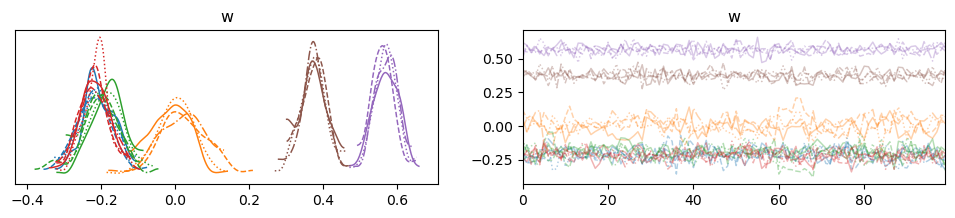

In [8]:
import arviz as az

az.plot_trace(trace)
plt.show()



In [9]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],-0.211,0.048,-0.310,-0.126,0.003,0.002,363.0,305.0,1.01
w[1],0.007,0.061,-0.106,0.122,0.005,0.004,144.0,212.0,1.03
w[2],-0.194,0.051,-0.295,-0.090,0.004,0.003,202.0,100.0,1.02
w[3],-0.216,0.042,-0.287,-0.124,0.002,0.001,447.0,359.0,1.00
w[4],0.567,0.033,0.501,0.631,0.001,0.001,609.0,357.0,1.01
w[5],0.374,0.036,0.310,0.447,0.001,0.001,591.0,417.0,0.99


In [10]:
def predict(Xtest, trace):
    from scipy.special import expit
    w_samples = trace.posterior["w"].stack(sample=("chain", "draw")).values.T
    logits = Xtest @ w_samples.T
    probs = expit(logits)
    mean_probs = probs.mean(axis=1)
    return mean_probs, (mean_probs > 0.5).astype(int)

# Example usage
probs, preds = predict(Xtest_scaled, trace)



In [11]:
accuracy_score(ytest,preds)

0.6602316602316602

In [12]:
f1_score(ytest,preds)

0.5407098121085595

In [13]:
values, counts = np.unique(preds, return_counts=True)

for val, count in zip(values, counts):
    print(f"Value: {val}, Count: {count}")

Value: 0, Count: 691
Value: 1, Count: 604


In [14]:
import pymc as pm
import numpy as np

with pm.Model():
    w = pm.Normal("w", mu=0, sigma=1, shape=Xtrain_scaled.shape[1])
    logits = pm.math.dot(Xtrain_scaled, w)
    y_obs = pm.Bernoulli("ytest", logit_p=logits, observed=ytrain)
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


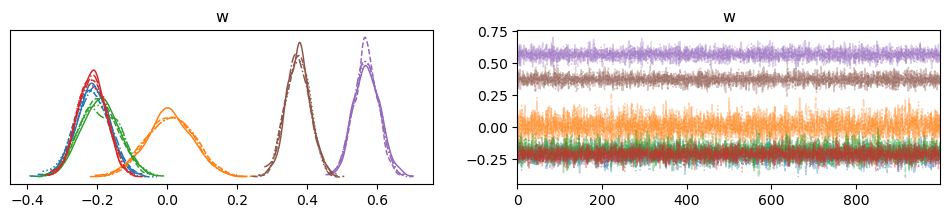

In [15]:
import arviz as az

az.plot_trace(trace)
plt.show()



In [16]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],-0.214,0.049,-0.306,-0.116,0.001,0.001,4332.0,2925.0,1.0
w[1],0.008,0.068,-0.118,0.149,0.001,0.001,3454.0,2968.0,1.0
w[2],-0.193,0.056,-0.296,-0.083,0.001,0.001,4149.0,2874.0,1.0
w[3],-0.215,0.041,-0.296,-0.136,0.001,0.000,4925.0,3276.0,1.0
w[4],0.568,0.036,0.494,0.636,0.000,0.000,5602.0,3055.0,1.0
w[5],0.373,0.035,0.308,0.443,0.000,0.000,6182.0,3037.0,1.0


In [17]:
def predict(Xtest, trace):
    from scipy.special import expit
    w_samples = trace.posterior["w"].stack(sample=("chain", "draw")).values.T
    logits = Xtest @ w_samples.T
    probs = expit(logits)
    mean_probs = probs.mean(axis=1)
    return mean_probs, (mean_probs > 0.5).astype(int)

# Example usage
probs, preds = predict(Xtest_scaled, trace)



In [18]:
values, counts = np.unique(preds, return_counts=True)

for val, count in zip(values, counts):
    print(f"Value: {val}, Count: {count}")

Value: 0, Count: 691
Value: 1, Count: 604


In [19]:
accuracy_score(ytest,preds)

0.6602316602316602

In [20]:
f1_score(ytest,preds)

0.5407098121085595